# Euclidean Alignment + Weighted TL

## Load dataset

In [1]:
import sys

In [2]:
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\csp')
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\func')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import moabb.datasets
import moabb.paradigms


from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class, process_s_data
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

In [26]:
dframe = pd.DataFrame

In [27]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [28]:
# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    data_path = '../../datasets/BCICIV2a/A{:02d}T.npz'.format(subj)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['s'] = deepcopy(ori_data[subj]['s'])
    mod_data[subj]['etyp'] = deepcopy(ori_data[subj]['etyp'])
    mod_data[subj]['epos'] = deepcopy(ori_data[subj]['epos'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['s'] = np.delete(mod_data[subj]['s'], np.s_[22:], 1)

## Preprocessing

### Apply Bandpass Filter

In [29]:
from scipy.signal import firwin, freqs, lfilter

In [30]:
# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [31]:
## PREPROCESSING ##

# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['s']
    
    mod_data[subj]['EEG_filtered'] = apply_bandpass(temp_raw_EEG, b)

In [32]:
dframe(mod_data[1]['EEG_filtered']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.020422,-0.022875,-0.020752,-0.024290,-0.024856,-0.026978,-0.014055,-0.021743,-0.024573,-0.027733,...,-0.025186,-0.022356,-0.023960,-0.029572,-0.028629,-0.025752,-0.020234,-0.024573,-0.024054,-0.019007
1,-0.028404,-0.031205,-0.030831,-0.033074,-0.033981,-0.033931,-0.020491,-0.029673,-0.036051,-0.038065,...,-0.031740,-0.030597,-0.034277,-0.040461,-0.039797,-0.034346,-0.029374,-0.034872,-0.033981,-0.029271
2,-0.022534,-0.027174,-0.026464,-0.029447,-0.028894,-0.029548,-0.017482,-0.027437,-0.032539,-0.034971,...,-0.024285,-0.029289,-0.032084,-0.038319,-0.037874,-0.032493,-0.028467,-0.033443,-0.032392,-0.028682
3,-0.027857,-0.027150,-0.032594,-0.035113,-0.038213,-0.037143,-0.019260,-0.029577,-0.040505,-0.041637,...,-0.035856,-0.031609,-0.039735,-0.045916,-0.046540,-0.041085,-0.032311,-0.039749,-0.039492,-0.030589
4,-0.064138,-0.066045,-0.067683,-0.079740,-0.082914,-0.087771,-0.040368,-0.065460,-0.080927,-0.091818,...,-0.087361,-0.067454,-0.079225,-0.097632,-0.098159,-0.089933,-0.064292,-0.082052,-0.082849,-0.061782


### Convert samples x n_electrodes -> no_trials x n_electrodes x samples 
Remember to process the filtered EEG with shape of samples x electrodes

In [33]:
# Iterate overall all_data
for subj in mod_data.keys():
    print('Processing for subject', subj)
    mod_data[subj]['all_trials'], mod_data[subj]['y'], _ = process_s_data(data=mod_data[subj], eeg_key='EEG_filtered', start_t=0.5, end_t=3.5, fs=250)

Processing for subject 1
Processing for subject 2
Processing for subject 3
Processing for subject 4
Processing for subject 5
Processing for subject 6
Processing for subject 7
Processing for subject 8
Processing for subject 9


In [34]:
mod_data[2]['all_trials'].shape

(144, 22, 750)

In [35]:
dframe(mod_data[5]['all_trials'][6]).iloc[:10]

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
0,2.831225,3.908294,4.449849,4.378324,3.742567,2.703605,1.307775,-0.408919,-2.290599,-4.026515,...,-3.934988,-3.078539,-2.011369,-0.861646,0.192806,0.994518,1.429399,1.528896,1.414543,1.317802
1,4.552508,5.900402,6.152449,5.226010,3.403669,1.273342,-0.632542,-1.959919,-2.534516,-2.362089,...,-4.288117,-4.128549,-3.374571,-2.117593,-0.630167,0.755886,1.699310,2.052092,1.845995,1.337277
2,4.040848,5.192079,5.402117,4.672942,3.285968,1.715717,0.279973,-0.873856,-1.699544,-2.192805,...,-5.330225,-4.911525,-4.056859,-2.824312,-1.390331,0.014043,1.130867,1.826411,2.081070,2.069634
3,3.429017,4.367521,4.607730,4.135970,3.124638,1.889428,0.611817,-0.651014,-1.836032,-2.805330,...,-5.934167,-5.142495,-3.934169,-2.513212,-1.105981,0.119408,1.018298,1.584724,1.865963,2.015373
4,3.608418,4.045117,4.080243,3.825804,3.409204,2.922179,2.212409,1.050827,-0.628231,-2.609484,...,-4.718487,-4.275966,-3.733652,-3.069747,-2.261631,-1.279024,-0.158012,1.047967,2.223742,3.281814
5,3.991446,4.108935,3.930405,3.574364,3.110047,2.547555,1.686041,0.297946,-1.609874,-3.700618,...,-3.648237,-3.251446,-2.710506,-2.094913,-1.448670,-0.720658,0.128474,1.159591,2.326735,3.512759
6,3.822723,5.666412,6.340582,5.781415,4.293528,2.477332,0.826080,-0.355372,-0.973503,-1.115745,...,-3.103053,-3.804356,-3.950902,-3.348587,-2.100468,-0.522067,0.955570,2.006688,2.452539,2.364979
7,3.740346,4.855241,5.011246,4.229082,2.809719,1.268153,-0.009607,-0.838442,-1.180222,-1.092079,...,-5.881179,-5.997063,-5.324623,-3.946722,-2.149172,-0.293058,1.224050,2.189421,2.533206,2.405074
8,3.354028,4.185194,4.205664,3.508617,2.399137,1.296841,0.408868,-0.249901,-0.745095,-1.133733,...,-5.957361,-5.987533,-5.491642,-4.454690,-3.001376,-1.341464,0.246939,1.559108,2.456476,2.974979
9,3.062213,3.871230,3.991827,3.514069,2.684576,1.821369,1.027980,0.235331,-0.629816,-1.515984,...,-6.550056,-6.024622,-5.098191,-3.890149,-2.519493,-1.067594,0.341394,1.628959,2.674813,3.423529


## Apply Data Alignment on raw EEG

In [36]:
from func.EA import apply_EA
from func.csp_matlab import csp_feat_ver5

In [37]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered', 'all_trials', 'y'])

In [38]:
# Iterate over all subjects to apply EA to all trials
# Define keys to be processed
process_key = ['all_trials']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    mod_data[subj]['all_trials_EA']  = apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  2
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  3
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  4
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  5
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  6
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  7
Found 1 key(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data

Processing subject  8
Found 1 key(s) in which EEG data is stored
Computing reference matri

In [39]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered', 'all_trials', 'y', 'RefEA', 'R_inv', 'all_trials_EA'])

In [40]:
dframe(mod_data[5]['RefEA']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,14.328524,11.726248,12.853534,13.460009,13.324563,12.833290,8.599128,10.032622,11.430014,11.947914,...,10.453244,8.978260,10.063086,10.356200,10.591482,10.368370,8.523855,9.091489,8.954617,7.284086
1,11.726248,12.189128,12.068785,12.005063,11.115135,10.704620,9.585176,10.951415,11.183878,11.297983,...,8.661832,9.831772,9.994492,10.134771,9.786477,9.249665,8.773573,8.982710,8.555737,7.341576
2,12.853534,12.068785,12.989954,12.958085,12.559108,11.727079,9.447175,10.933390,12.099687,12.261040,...,9.860789,9.985911,10.896517,10.964286,10.884414,10.363270,9.425194,9.841825,9.485840,8.048208
3,13.460009,12.005063,12.958085,13.901419,13.360468,13.040900,8.743616,10.789745,12.002130,12.983466,...,10.592118,9.933955,10.824847,11.518472,11.488113,11.111100,9.485104,10.103794,9.896453,8.211019
4,13.324563,11.115135,12.559108,13.360468,13.747653,13.403249,8.458048,10.077310,11.778675,12.620037,...,11.486386,9.451242,10.826558,11.346731,11.731168,11.610288,9.476050,10.231591,10.195624,8.422172


In [41]:
# Sanity check that each subject EA data equal to identity matrix
for subj in mod_data.keys():
    all_trials = mod_data[subj]['all_trials_EA']
    all_cov = 0
    
    for tr in all_trials:
        all_cov += np.cov(tr, rowvar=True, ddof=1)
    
    all_cov = all_cov/len(all_trials)
    
    assert np.round(np.diag(all_cov)).sum() == 22
    print('Subject %d OK!' %subj)

Subject 1 OK!
Subject 2 OK!
Subject 3 OK!
Subject 4 OK!
Subject 5 OK!
Subject 6 OK!
Subject 7 OK!
Subject 8 OK!
Subject 9 OK!


# Try comparing SVM, SVM_EA, LDA, LDA_EA
Randomized 10 trials 30 times from each subject, then average result.  
For EA approach, also add the features from source subject to build model   
There are four patterns that will be compared for each model
1. **Pattern 1**: train on target training 10 trials_no_EA, test on target test_no_EA
2. **Pattern 2**: train on target training 10 trials EA, test on target test EA (this will not contribute much)  
3. **Pattern 3**: target training trials + source trials without EA  
    training using these trials  
    then test trials to evaluate model (should worsen the model)
4. **Pattern 4**: target training trials first is EA-ed with all source trials, should be 10 + (8 * 144) trials (1162 trials)  
    training using these trials  
    then test trials is EA-ed with training trials of target subject

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

In [90]:
import random
def svm_lda_EA(data, tgt_subj, n_iter=30, samples_tr=10, key = ['all_trials', 'all_trials_EA'], pattern='pattern1'):
    #pattern = 'pattern1'
    #key = ['all_trials', 'all_trials_EA']
    #tgt_subj = 6
    #data = TL_data
    #n_iter = 30
    #samples_tr = 10

    # ===== TARGET DATA ======
    # Grab the X and y data for pattern1 and pattern 2, use EA data
    if (pattern == 'pattern2') or (pattern == 'pattern4') :
        print('With EA')
        X_tgt = deepcopy(data['tgt'][tgt_subj][key[1]])
    else:
        print('Without EA')
        X_tgt = deepcopy(data['tgt'][tgt_subj][key[0]])

    y_tgt = deepcopy(data['tgt'][tgt_subj]['y'])


    # ====== SOURCE DATA ======
    # Subjects that act as source subject
    sources = [i for i in data['src'].keys() if i != tgt_subj]

    X_src = np.array([])
    y_src = np.array([])
    # Stacking all source subject's X and y trials_EA for pattern 3 and pattern 4 who uses source trials   
    if pattern == 'pattern4' :

        print('Getting sourc trials from subject ', sources)
        print('Stacking trials inside {} key'.format(key[1]))

        for src_subj in sources:
            current_X = deepcopy(data['src'][src_subj][key[1]])
            current_y = deepcopy(data['src'][src_subj]['y'])

            if len(X_src) == 0:
                X_src = current_X
                y_src = current_y
            else :
                X_src = np.concatenate([X_src, current_X], axis=0)
                y_src = np.concatenate([y_src, current_y])   

    elif pattern == 'pattern3' :

        print('Getting source trials from subject ', sources)
        print('Stacking trials inside {} key'.format(key[0]))

        for src_subj in sources:
            current_X = deepcopy(data['src'][src_subj][key[0]])
            current_y = deepcopy(data['src'][src_subj]['y'])

            if len(X_src) == 0:
                X_src = current_X
                y_src = current_y
            else :
                X_src = np.concatenate([X_src, current_X], axis=0)
                y_src = np.concatenate([y_src, current_y])    

    # Sanity check covariance equal 22 (EA) or not (non EA)
    cov = 0

    # Whether all X consist of X_src and X_tgt or only X_tgt
    if (pattern == 'pattern3') or (pattern == 'pattern4') :
        all_X = np.concatenate([X_tgt, X_src])
    else:
        all_X = X_tgt

    # Compute the toal covariance of all X
    for i, tr in enumerate(all_X):
        cov += np.cov(tr, rowvar=True, ddof=1)

    #print(i)
    cov = cov/len(all_X) 

    # EA data diagonal element of total avg cov != 22
    if (pattern == 'pattern2') or (pattern == 'pattern4'): 
        #print(int(np.diag(cov).sum()))
        assert np.round(np.diag(cov).sum()) == 22

    # Non EA data diagonal element total avg cov != 22
    else:
        #print(int(np.diag(cov).sum()))
        assert np.round(np.diag(cov).sum()) != 22

    all_lda = []
    all_svm = []
    
    for i in range(n_iter):
        print(i+1, end=' ')
        ids_train = random.sample(range(len(y_tgt)), samples_tr)

        while (y_tgt[ids_train] == 1).sum() != 5:
            ids_train = random.sample(range(len(y_tgt)), samples_tr)

        assert (y_tgt[ids_train] == 1).sum() == 5

        #print('{}, idx tr trial : {}'.format(i, ids_train))

        ids_test = np.delete(np.arange(0, len(X_tgt)), ids_train)

        XtrRaw = X_tgt[ids_train]
        XteRaw = X_tgt[ids_test]
        ytr = y_tgt[ids_train]
        yte = y_tgt[ids_test]

        if (pattern == 'pattern1') or (pattern == 'pattern2'):
            feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr)

            assert len(feat_train) == len(ytr)
            assert len(feat_test) == len(yte)

        else:
            # Stack the source trials into target test set 
            XteRaw = np.concatenate([X_src, XteRaw], axis=0)

            # Build feature
            feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr)

            # Then grab part of feat test that belongs to X_src and add to feat_train, do this also for ytr
            # NEED TO INVESTIGATE ABOUT THIS
            feat_train = np.concatenate([feat_train, feat_test[:len(X_src)]], axis=0)
            ytr = np.concatenate([ytr, y_src], axis=0)

            # Only grab part of feat_test that is originally XteRaw
            feat_test = feat_test[len(X_src):]


            assert len(feat_train) == len(ytr)
            assert len(feat_test) == len(yte)

            # print(len(ytr))
            # print(len(y_src))
            # print(feat_train.shape)
            # print(feat_test.shape)
            # print(XteRaw.shape)
        
        # Define model, train, and evaluate
        model_lda = LDA()
        model_svm = SVC()

        model_lda.fit(feat_train, ytr)
        model_svm.fit(feat_train, ytr)

        sc_lda = model_lda.score(feat_test, yte)
        sc_svm = model_svm.score(feat_test, yte)

        all_lda.append(sc_lda)
        all_svm.append(sc_svm)

        #print('Iteration {}, score: {:.5f}'.format(i, sc_lda))
        #print(' ')
    
    mean_lda = np.mean(np.array(all_lda))*100
    std_lda = np.std(np.array(all_lda))*100
    mean_svm = np.mean(np.array(all_svm))*100
    std_svm = np.std(np.array(all_svm))*100
    
    print('\nMean accuracy of lda: {:.3f}, svm: {:.3f}'.format(mean_lda, mean_svm))
    
    print('')
    return mean_lda, std_lda, mean_svm, std_svm

In [91]:
pattern = ['pattern1', 'pattern2', 'pattern3', 'pattern4']

for t_subj in TL_data['tgt'].keys():
    print('Processing subject',t_subj)
    for pat in pattern:
        print('Processing ', pat)
        
        TL_data['tgt'][t_subj][pat] = {}
        temp_score = TL_data['tgt'][t_subj][pat]
        temp_score['mean_lda'], temp_score['std_lda'],\
        temp_score['mean_svm'], temp_score['std_svm'] = svm_lda_EA(TL_data, t_subj, n_iter=30, samples_tr=10, key=['all_trials', 'all_trials_EA'], pattern=pat)

Processing subject 1
Processing  pattern1
Without EA
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 65.771, svm: 80.100

Processing  pattern2
With EA
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 66.716, svm: 80.970

Processing  pattern3
Without EA
Getting source trials from subject  [2, 3, 4, 5, 6, 7, 8, 9]
Stacking trials inside all_trials key
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 77.164, svm: 74.204

Processing  pattern4
With EA
Getting sourc trials from subject  [2, 3, 4, 5, 6, 7, 8, 9]
Stacking trials inside all_trials_EA key
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 81.667, svm: 79.502

Processing subject 2
Processing  pattern1
Without EA
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Mean accuracy of lda: 

In [72]:
TL_data['tgt'][1].keys()

dict_keys(['all_trials', 'all_trials_EA', 'y', 'pattern1', 'pattern2', 'pattern3', 'pattern4', 'pattern_1', 'pattern_2', 'pattern_3', 'pattern_4'])

In [94]:
pattern = ['pattern1', 'pattern2', 'pattern3', 'pattern4']

for pat in pattern:
    print(' ===== {} ==== '.format(pat))
    print('\t\t\t Score LDA\t Score SVM')
    
    for t_subj in TL_data['tgt'].keys():
        score_svm = TL_data['tgt'][t_subj][pat]['mean_svm']
        #std_svm = TL_data['tgt'][t_subj][pat]['std_svm']
        score_lda = TL_data['tgt'][t_subj][pat]['mean_lda']
        #std_lda = TL_data['tgt'][t_subj][pat]['std_lda']

        print('Subject{:02d} :\t\t {:.3f}\t\t {:.3f} '.format(t_subj, score_lda, score_svm))

 ===== pattern1 ==== 
			 Score LDA	 Score SVM
Subject01 :		 65.771		 80.100 
Subject02 :		 52.736		 53.781 
Subject03 :		 81.070		 92.040 
Subject04 :		 53.781		 57.960 
Subject05 :		 51.219		 51.791 
Subject06 :		 53.905		 55.647 
Subject07 :		 56.990		 62.289 
Subject08 :		 83.980		 94.701 
Subject09 :		 69.104		 79.328 
 ===== pattern2 ==== 
			 Score LDA	 Score SVM
Subject01 :		 66.716		 80.970 
Subject02 :		 51.517		 53.930 
Subject03 :		 81.891		 91.517 
Subject04 :		 54.876		 56.443 
Subject05 :		 53.184		 53.706 
Subject06 :		 54.005		 56.318 
Subject07 :		 56.741		 58.507 
Subject08 :		 81.940		 93.159 
Subject09 :		 70.398		 78.557 
 ===== pattern3 ==== 
			 Score LDA	 Score SVM
Subject01 :		 77.164		 74.204 
Subject02 :		 49.328		 48.980 
Subject03 :		 78.632		 81.045 
Subject04 :		 57.935		 57.090 
Subject05 :		 50.149		 49.876 
Subject06 :		 54.876		 55.174 
Subject07 :		 55.945		 56.716 
Subject08 :		 89.776		 89.179 
Subject09 :		 69.179		 69.279 
 ===== pattern4 ==== 


## Result

In [121]:
# Store each score and std into list
all_sc = {}


# Accessing each patter
for pat in pattern:
    print('Processing ',pat)
    print('Subject', end=' ')
    all_sc[pat] = {}
    all_sc[pat]['score_lda'] = []
    all_sc[pat]['std_lda'] = []
    all_sc[pat]['score_svm'] = []
    all_sc[pat]['std_svm'] = []

    
    for t_subj in TL_data['tgt'].keys():
        print(t_subj, end = ' ')
        all_sc[pat]['score_lda'].append(TL_data['tgt'][t_subj][pat]['mean_lda'])
        all_sc[pat]['std_lda'].append(TL_data['tgt'][t_subj][pat]['std_lda'])
        all_sc[pat]['score_svm'].append(TL_data['tgt'][t_subj][pat]['mean_svm'])
        all_sc[pat]['std_svm'].append(TL_data['tgt'][t_subj][pat]['std_svm'])
    print('')

Processing  pattern1
Subject 1 2 3 4 5 6 7 8 9 
Processing  pattern2
Subject 1 2 3 4 5 6 7 8 9 
Processing  pattern3
Subject 1 2 3 4 5 6 7 8 9 
Processing  pattern4
Subject 1 2 3 4 5 6 7 8 9 


In [120]:
all_sc['pattern2']['score_lda']

[66.71641791044775,
 51.51741293532339,
 81.8905472636816,
 54.87562189054726,
 53.18407960199005,
 54.004975124378106,
 56.7412935323383,
 81.94029850746269,
 70.39800995024876]

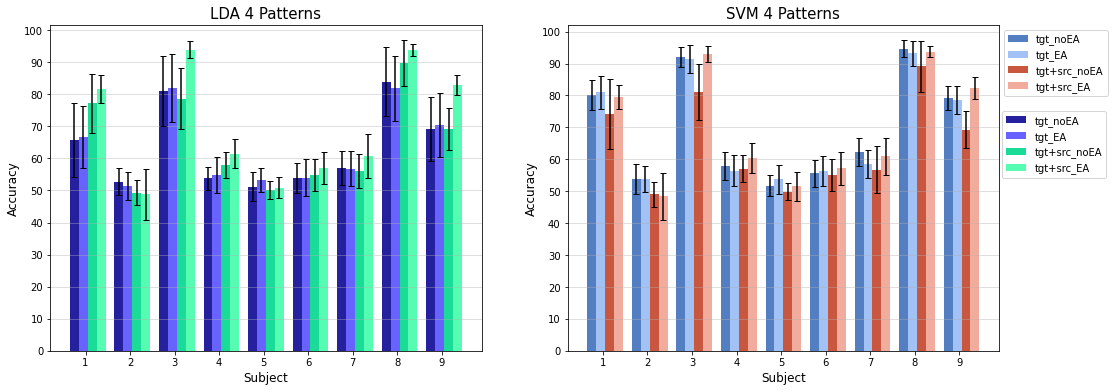

In [243]:
# Position for each subject, adn necessary variables
xpos = np.arange(1, 18, step=2)
w = 0.4
clist1= {
    'pattern1' : '#24209e',
    'pattern2' : '#6863ff',
    'pattern3' : '#1adb98',
    'pattern4' : '#56fcb1'
}

clist2 = {        
    'pattern1' : '#537ec2',
    'pattern2' : '#a2c2f5',
    'pattern3' : '#c95740',
    'pattern4' : '#f2ac9d'
}

label = {
    'pattern1' : 'tgt_noEA',
    'pattern2' : 'tgt_EA',
    'pattern3' : 'tgt+src_noEA',
    'pattern4' : 'tgt+src_EA'

}

# Bar + line plot of LDA result
fig, (lda0, lda1) = plt.subplots(1, 2, figsize=(17, 6))
lda0.set_title('LDA 4 Patterns', fontsize=15)
lda1.set_title('SVM 4 Patterns', fontsize=15)


for i, pat in enumerate(pattern):
    lda0.bar(xpos+w*i, all_sc[pat]['score_lda'], yerr=all_sc[pat]['std_lda'], capsize=3, color=clist1[pat], width=w, label=label[pat])
    lda1.bar(xpos+w*i, all_sc[pat]['score_svm'], yerr=all_sc[pat]['std_svm'], capsize=3, color=clist2[pat], width=w, label=label[pat])

lda0.set_yticks(np.arange(0, 101, step=10))
lda0.set_xticks(xpos+0.5)
lda0.set_xticklabels(np.arange(1, 10))
lda0.set_xlabel('Subject', fontsize=12)
lda0.set_ylabel('Accuracy', fontsize=12)
lda0.grid(axis='y', alpha=0.5)
lda0.legend(bbox_to_anchor=(2.46, 0.75))

lda1.set_yticks(np.arange(0, 101, step=10))
lda1.set_xticks(xpos+0.5)
lda1.set_xticklabels(np.arange(1, 10))
lda1.set_xlabel('Subject', fontsize=12)
lda1.set_ylabel('Accuracy', fontsize=12)
lda1.grid(axis='y', alpha=0.5)
lda1.legend(bbox_to_anchor=(1, 1))

plt.savefig('./img/svm_lda_4pat_bar.png')

# Visualize using T-SNE

In [20]:
from sklearn.manifold import TSNE
from func.csp_matlab import csp_feat_ver3

In [47]:
data = mod_data

for subj in data.keys():
    # Compute csp feature
    data[subj]['csp_feat'] = csp_feat_ver3(data[subj], key='all_trials')
    data[subj]['csp_feat_EA'] = csp_feat_ver3(data[subj], key='all_trials_EA')
    
    # Compute sne representation
    data[subj]['sne'] = {}
    data[subj]['sne']['no_EA'] = TSNE().fit_transform(data[subj]['csp_feat'])
    data[subj]['sne']['EA'] = TSNE().fit_transform(data[subj]['csp_feat_EA'])

In [48]:
import seaborn as sns
palette = np.array(sns.color_palette(n_colors=10))

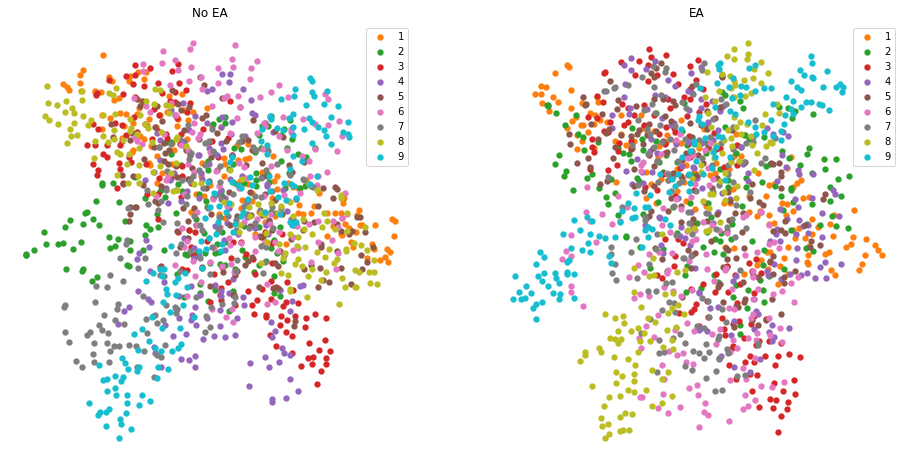

In [53]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for subj in mod_data.keys():
    ax0.set_title('No EA')
    ax0.scatter(mod_data[subj]['sne']['no_EA'][:, 0], mod_data[subj]['sne']['no_EA'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('EA')
    ax1.scatter(mod_data[subj]['sne']['EA'][:, 0], mod_data[subj]['sne']['EA'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

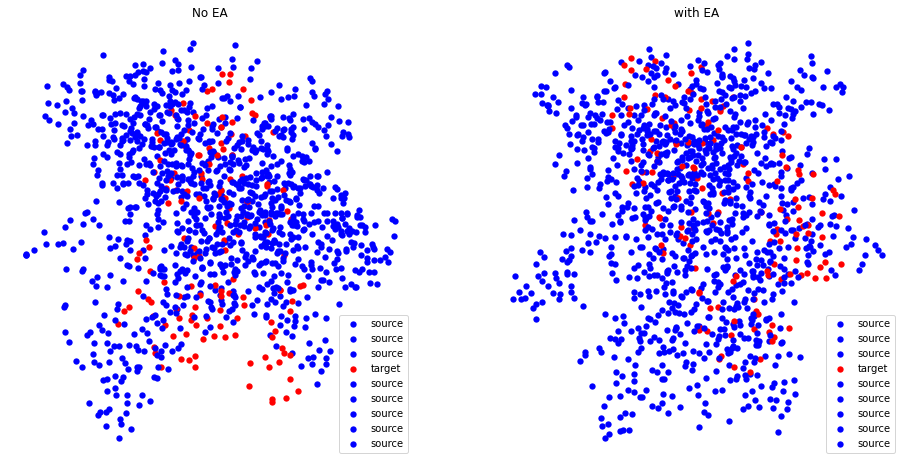

In [60]:
# target vs subject
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for subj in mod_data.keys():
    ax0.set_title('No EA')
    tgt_subj = 4
    if subj == tgt_subj:
        ax0.scatter(mod_data[subj]['sne']['no_EA'][:, 0], mod_data[subj]['sne']['no_EA'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(mod_data[subj]['sne']['no_EA'][:, 0], mod_data[subj]['sne']['no_EA'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if subj == tgt_subj:
        ax1.scatter(mod_data[subj]['sne']['EA'][:, 0], mod_data[subj]['sne']['EA'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(mod_data[subj]['sne']['EA'][:, 0], mod_data[subj]['sne']['EA'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')
    
plt.savefig('SNE_plot.png')